In [1]:
import open3d
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import copy
import matplotlib.pyplot as plt

from time import sleep
from scipy.signal import argrelmin, argrelmax
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers
# import utils.grid_search as grid_search

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
def find_candidate_global_pos(std_values, delta):
    global_pos = [0]
    prev_t = 0
    for current_t in range(len(std_values)):
        if np.abs(std_values[current_t] - std_values[prev_t]) > delta:
            global_pos.append(current_t)
            prev_t = current_t
            
    return global_pos

def find_cutoffs(std_values, target_fps, min_std):
    cutoffs = argrelmin(std_values, order=target_fps // 2)[0]
    # return cutoffs[np.where(np.abs(std_values[cutoffs] - min_std) < 0.5)[0]]
    return cutoffs[np.where(std_values[cutoffs] - min_std < 0)[0]]
    
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))


In [18]:
sequence = 1
    
config = Config(
    feature_dir="data/features",
    sequence_dir="data/raw_data",
    experiment="exp_9",
    trial="trial_1",
    subject="subject-1",
    sequence=f"{sequence:02d}",
    groundtruth_dir="data/trajectories/groundtruth",
    output_dir="data/trajectories/cache",
    voxel_size=0.03,
    min_std=1.5
)

In [19]:
cache_path = f"data/trajectories/cache/{config.experiment}/{config.get_file_name()}.local.npz"
local_t = np.load(cache_path)["local_t"]

sequence_ts = np.load(cache_path)["sequence_ts"] 
num_frames = len(sequence_ts)

local_pcds = []
fpfh_feats = []

for t in tqdm.trange(num_frames):
    feature_file = os.path.join(config.get_feature_dir(), f"{sequence_ts[t]}.secondary.npz")
    pcd = FCGF.get_features(feature_file, pcd_only=True)
    local_pcds.append(pcd)

100%|██████████| 335/335 [00:08<00:00, 41.82it/s]


In [4]:
std_values = []

for t in range(len(sequence_ts)):
    depth_img = Image.open(os.path.join(config.get_sequence_dir(include_secondary=True), f"frame-{sequence_ts[t]}.depth.png")).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

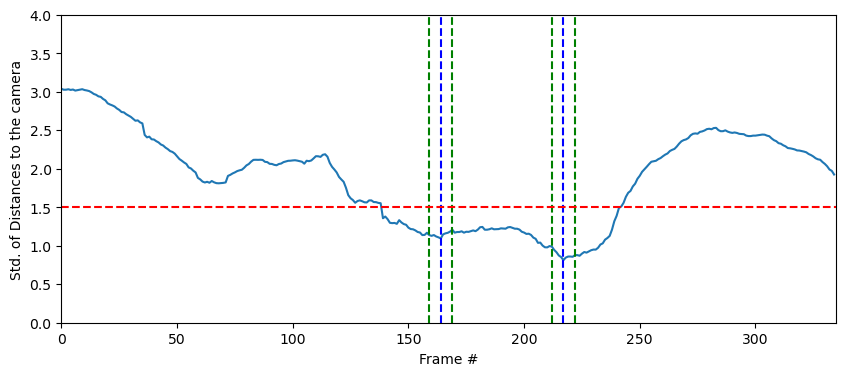

In [20]:
cutoffs = find_cutoffs(std_values, config.target_fps, config.min_std)

plt.figure(figsize=(10, 4))
plt.plot(std_values)

for x in cutoffs:
    plt.axvline(x - config.cutoff_margin, c="g", linestyle="--")
    plt.axvline(x, c="b", linestyle="--")
    plt.axvline(x + config.cutoff_margin, c="g", linestyle="--")
    
plt.axhline(y=config.min_std, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(std_values))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [21]:
cutoffs = find_cutoffs(std_values, config.target_fps, config.min_std)
cutoffs = np.concatenate([[0], cutoffs, [num_frames - 1]])

cutoffs = [[cutoffs[i] + config.cutoff_margin, cutoffs[i + 1] - config.cutoff_margin] for i in range(len(cutoffs) - 1)]
# check if the first frame in the last cutoff is the last frame in the sequence 
cutoffs[-1][0] = min(num_frames - 1, cutoffs[-1][0])

cutoffs = [c for c in cutoffs if c[0] < c[1]]

In [22]:
trajectory_t = [np.identity(4)]

for t in range(1, num_frames):
    trajectory_t.append(np.dot(trajectory_t[t - 1], local_t[t]))
    
trajectory_pcds = []
for t in range(cutoffs[0][0], cutoffs[0][1]):
    local_temp = copy.deepcopy(local_pcds[t])
    local_temp.transform(trajectory_t[t])
    trajectory_pcds.append(local_temp)
    
trajectory = helpers.merge_pcds(trajectory_pcds, config.voxel_size)
open3d.visualization.draw_geometries([trajectory])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [4]:
experiment = "exp_5"
voxel_size = 0.1

output_dir = f"data/trajectories/cache/local/{experiment}/{voxel_size}"

if not os.path.exists(output_dir): os.makedirs(output_dir)

for cache_file in glob.glob(f"data/trajectories/estimated_all/{experiment}/{voxel_size}/*.npz"):
    local_t = np.load(cache_file)["local_t"] 
    np.savez_compressed(f"{output_dir}/{os.path.basename(cache_file)}", local_t=local_t)

In [2]:
def get_limits(pcd):
    pcd_points = np.asarray(pcd.points)

    x_min, y_min, z_min = np.min(pcd_points, axis=0)
    x_max, y_max, z_max = np.max(pcd_points, axis=0)

    return x_min, x_max, y_min, y_max, z_min, z_max

def get_grid(pcd, cell_size):
    x_min, x_max, y_min, y_max, z_min, z_max = get_limits(pcd)
    y_val = np.mean([y_min, y_max])

    points = []
    x_n = int((x_max - x_min) // cell_size)
    z_n = int((z_max - z_min) // cell_size)
    for i in range(z_n):
        z0 = float(z_min + cell_size * (i + 1))
        for j in range(x_n):
            x0 = float(x_min + cell_size * (j + 1))
            points.append([x0, y_val, z0])

    return points

def filter_indices(points, p, cell_size):
    px_min = p[0] - cell_size
    px_max = p[0] + cell_size
    pz_min = p[2] - cell_size
    pz_max = p[2] + cell_size
    xf = np.logical_and(points[:, 0] > px_min, points[:, 0] < px_max)
    zf = np.logical_and(points[:, 2] > pz_min, points[:, 2] < pz_max)
    return np.logical_and(xf, zf)

def get_cell_features(feature_file, p, cell_size):
    data = np.load(feature_file)
    scores = data["scores"]

    f = filter_indices(data["keypts"], p, cell_size)
    f = np.where(f)[0]

    features = open3d.registration.Feature()
    features.data = data["features"][f].T

    keypts = open3d.geometry.PointCloud()
    keypts.points = open3d.utility.Vector3dVector(data["keypts"][f])
    # keypts.transform(np.loadtxt("temp/rotation_transformation.txt"))

    return keypts, features, scores

def register_cell(source, target, source_feat, target_feat, n_ransac, threshold, cell_stat):
    if len(target.points) < 2000 or cell_stat[0] == -1:
        return None
    
    result_ransac = registration.exec_global_reg(source, target, source_feat, target_feat, n_ransac=n_ransac, threshold=threshold)
    
    if (result_ransac.fitness < cell_stat[1]) or (result_ransac.fitness > cell_stat[2]):
        return None
    
    return result_ransac

def global_registration(src_feature_file, tgt_feature_file, voxel_size, cell_size, refine_enabled=False):
    global_pcd = FCGF.get_features(tgt_feature_file, pcd_only=True)
    # center_pts = get_grid(global_pcd, cell_size)

    center_pts = np.loadtxt("temp/center_points_cell_2_v2.txt")
    cell_stats = np.loadtxt("temp/cell_stats_cell_2_v2.txt")
    
    src_feature_file = os.path.join(src_feature_file)
    source, source_feat, _ = FCGF.get_features(src_feature_file)
    
    targets = []
    target_feats = []
    
    for i in range(len(center_pts)):
        target, target_feat, _ = get_cell_features(tgt_feature_file, center_pts[i], cell_size)
        targets.append(target)
        target_feats.append(target_feat)

    reg_result = None
    
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = []
        for i in range(len(center_pts)):
            results.append(executor.submit(register_cell, source, targets[i], source_feat, target_feats[i], 3, 0.05, cell_stats[i]))
            
        for i in range(len(center_pts)):
            result_ransac = results[i].result()
            
            if not result_ransac: continue
            
            if reg_result is None or (len(reg_result.correspondence_set) < len(result_ransac.correspondence_set) and reg_result.fitness < result_ransac.fitness):
                reg_result = result_ransac
    
    if refine_enabled and reg_result is not None:
        reg_result = registration.exec_local_reg(source, global_pcd, threshold=0.05, trans_init=reg_result.transformation, max_iteration=200, p2p=False)
    
    return source, global_pcd, reg_result

In [92]:
min_std = 0.5
threshold = 0.5
target_fps = 20
voxel_size = 0.03
cutoff_margin = 5 # frames

experiment = "exp_5"
trial = "trial_4"
subject = "subject-2"
sequence = "01"

sequence_dir = f"data/raw_data/{experiment}/{trial}/secondary/{subject}/{sequence}/frames"

feature_dir = os.path.join("data/features", experiment, trial, str(voxel_size), subject, sequence)

sequence_ts = fread.get_timstamps(feature_dir, ext=".secondary.npz")
num_frames = len(sequence_ts)

file_name = f"{experiment}__{trial}__{subject}__{sequence}"

In [93]:
sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")
sequence_ts = helpers.sample_timestamps(sequence_ts, target_fps)
num_frames = len(sequence_ts)

In [94]:
std_values = []

for t in range(len(sequence_ts)):
    depth_img = Image.open(os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png")).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

In [95]:
device_0_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/exp_5", trial, "global", "device-0"), ext=".depth.png")
device_1_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/exp_5", trial, "global", "device-1"), ext=".depth.png")
device_2_ts = fread.get_timstamps_from_images(os.path.join("data/raw_data/exp_5", trial, "global", "device-2"), ext=".depth.png")

y = [[], [], []]
x = []

for i in range(num_frames):
    y[0].append(nearest(device_0_ts, sequence_ts[i]))
    y[1].append(nearest(device_1_ts, sequence_ts[i]))
    y[2].append(nearest(device_2_ts, sequence_ts[i]))
    
    y[0][i] = np.abs(y[0][i] - sequence_ts[i]) * 1e-6
    y[1][i] = np.abs(y[1][i] - sequence_ts[i]) * 1e-6
    y[2][i] = np.abs(y[2][i] - sequence_ts[i]) * 1e-6

global_frame_delays = np.array(y)
global_frame_delays_inds = np.ones(global_frame_delays.shape, dtype=np.int8)

for r, c in np.argwhere(global_frame_delays > 100):
    global_frame_delays_inds[r, c] = 0
    
global_frame_delays_inds = np.sum(global_frame_delays_inds, axis=0)
global_frame_delays_inds = np.where(global_frame_delays_inds == 3, 1, 0)

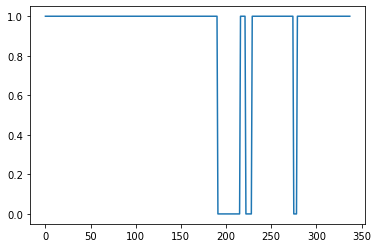

In [96]:
plt.plot(global_frame_delays_inds)

In [97]:
delta = 0.1
global_pos = [0]
for t in range(num_frames):
    if global_frame_delays_inds[t] == 0: continue
    
    if t - global_pos[-1] >= target_fps * 0.8: 
        global_pos.append(t)
        continue
    
    if (np.abs(std_values[t] - std_values[global_pos[-1]]) > delta) and (t - global_pos[-1] > target_fps * 0.5):
        global_pos.append(t)
        
global_pos = np.array(global_pos)

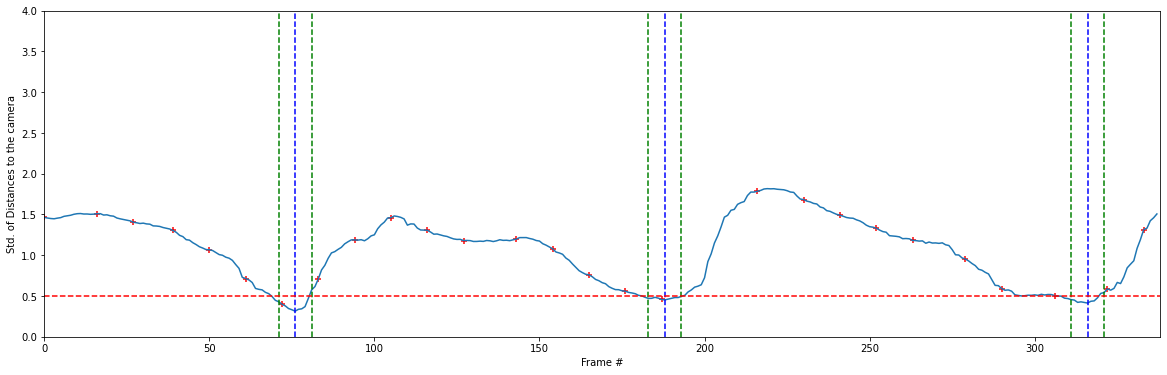

In [98]:
cutoffs = find_cutoffs(std_values, target_fps, min_std)

plt.figure(figsize=(20, 6))
plt.plot(std_values)

plt.scatter(global_pos, std_values[global_pos], c="r", marker="+")

for x in cutoffs:
    plt.axvline(x - cutoff_margin, c="g", linestyle="--")
    plt.axvline(x, c="b", linestyle="--")
    plt.axvline(x + cutoff_margin, c="g", linestyle="--")

plt.axhline(y=min_std, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(std_values))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [99]:
cache_path = f"data/trajectories/estimated_stationary_v2/{experiment}\{file_name}.npz"
local_t = np.load(cache_path)["local_t"] 

local_pcds = []
fpfh_feats = []

for t in tqdm.trange(num_frames):
    feature_file = os.path.join(feature_dir, f"{sequence_ts[t]}.secondary.npz")
    pcd = FCGF.get_features(feature_file, pcd_only=True)
    local_pcds.append(pcd)

In [101]:
# trajectory_t = [np.identity(4)]

# for t in range(1, num_frames):
#     trajectory_t.append(np.dot(trajectory_t[t - 1], local_t[t]))
    
# trajectory_pcds = []
# for t in range(num_frames):
#     local_temp = copy.deepcopy(local_pcds[t])
#     local_temp.transform(trajectory_t[t])
#     trajectory_pcds.append(local_temp)
    
# trajectory = helpers.merge_pcds(trajectory_pcds, 0.03)
# open3d.visualization.draw_geometries([trajectory])

In [102]:
cutoffs = find_cutoffs(std_values, target_fps, min_std)
cutoffs = np.concatenate([[0], cutoffs, [num_frames - 1]])

cutoffs = [[cutoffs[i] + cutoff_margin, cutoffs[i + 1] - cutoff_margin] for i in range(len(cutoffs) - 1)]
# check if the first frame in the last cutoff is the last frame in the sequence 
cutoffs[-1][0] = min(num_frames - 1, cutoffs[-1][0])

cutoffs = [c for c in cutoffs if c[0] < c[1]]

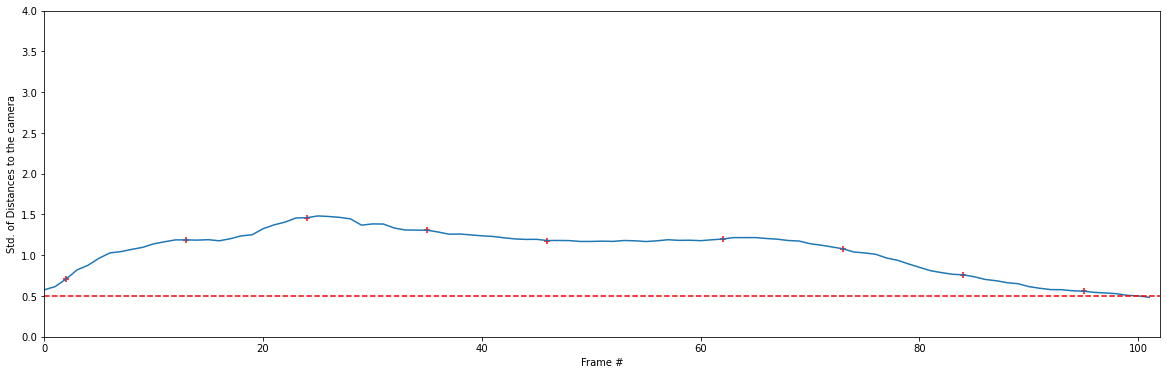

In [103]:
start_t, end_t = cutoffs[1]
window = std_values[start_t:end_t]

# global_inds = find_candidate_global_pos(window, delta=0.1)

global_inds = global_pos[np.logical_and(global_pos >= start_t, global_pos <= end_t)] - start_t

plt.figure(figsize=(20, 6))
plt.plot(window)

plt.scatter(global_inds, window[global_inds], c="r", marker="+")

plt.axhline(y=min_std, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(window))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [104]:
global_t = [np.identity(4) for _ in range(num_frames)]

for start_t, end_t in cutoffs:
    # start_t, end_t = cutoffs[2]
    global_inds = global_pos[np.logical_and(global_pos >= start_t, global_pos <= end_t)]

    global_target_t = []
    found_correct_global = False
    found_correct_global_at = -1

    for t in tqdm.trange(len(global_inds)):
        if found_correct_global:
            break
        else:
            source_feature_file = os.path.join(feature_dir, f"{sequence_ts[global_inds[t]]}.secondary.npz")
            target_feature_file = os.path.join(feature_dir, f"{sequence_ts[global_inds[t]]}.global.npz")
            # target_feature_file = os.path.join("data/reference/larc_kitchen.npz")
            source, target, reg_result = global_registration(source_feature_file, target_feature_file, voxel_size, cell_size=2, refine_enabled=True)
            global_target_t.append(reg_result.transformation if reg_result else np.identity(4))
            # registration.print_registration_result(source, target, reg_result)
            
        if t > 1 and not found_correct_global:
            total = 0
            for i in range(t, t - 3, -1):
                if np.sum(global_target_t[i]) == 4:
                    total += 1
                    
            if total > 1: continue
            
            try:
                global_target_t[t - 2], global_target_t[t - 1], global_target_t[t] = grid_search.validate(
                    global_target_t[t - 2], global_target_t[t - 1], global_target_t[t], 
                    helpers.merge_transformations(global_inds[t - 2], global_inds[t - 1], local_t),
                    helpers.merge_transformations(global_inds[t - 1], global_inds[t], local_t),
                    max_rot=2, max_dist=0.1
                )
                found_correct_global = True
                found_correct_global_at = t
            except Exception as e:
                continue
            
    if found_correct_global:
        global_t[global_inds[found_correct_global_at]] = global_target_t[found_correct_global_at]

        for t in range(global_inds[found_correct_global_at] + 1, end_t):
            global_t[t] = np.dot(global_t[t - 1], local_t[t])
            
        for t in range(global_inds[found_correct_global_at] - 1, start_t - 1, -1):
            global_t[t] = np.dot(global_t[t + 1], helpers.inv_transform(local_t[t + 1]))
                
        # else:
        #     print("     :: Finding correct point failed. Registering every frame globally.")
        #     for t in tqdm.tqdm(range(start_t, end_t)):
        #         source_feature_file = os.path.join(feature_dir, f"{sequence_ts[t]}.secondary.npz")
        #         target_feature_file = os.path.join(feature_dir, f"{sequence_ts[t]}.global.npz")
        #         source, target, reg_result = grid_search.global_registration(source_feature_file, target_feature_file, voxel_size, cell_size=3)
        #         global_t[t] = reg_result.transformation

100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


In [105]:
start_t, end_t = cutoffs[1]

fragment = []

for t in range(start_t, end_t):
    local_temp = copy.deepcopy(local_pcds[t])
    local_temp.transform(global_t[t])
    fragment.append(local_temp)
    
fragment = helpers.merge_pcds(fragment, 0.03)
fragment.paint_uniform_color([0.5, 0.5, 0.5])

open3d.visualization.draw_geometries([fragment, target])

In [106]:
fragment = []

for t in range(num_frames):
    if np.sum(global_t[t]) == 4: continue
    
    local_temp = copy.deepcopy(local_pcds[t])
    local_temp.transform(global_t[t])
    fragment.append(local_temp)
    
fragment = helpers.merge_pcds(fragment, 0.03)
fragment.paint_uniform_color([0.5, 0.5, 0.5])

open3d.visualization.draw_geometries([fragment, target])